In [1]:
%matplotlib notebook
import numpy as np
import glob, os
import g0_init_cfg as ic
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from astropy.io import fits

# ----- Importing IRAF from the root directory ----- #
current_dir = os.getcwd()
os.chdir(ic.dir_iraf)

from pyraf import iraf
from pyraf.iraf import gemini, gmos

os.chdir(current_dir)
iraf.chdir(current_dir)

uparm parameter list `/home/jlee/anaconda3/envs/geminiconda/iraf/noao/imred/ccdred/ccdtest/ccdtest.par' inconsistent with default parameters for IrafPkg `ccdtest'


In [2]:
# Find the gaps
flat = np.loadtxt(ic.lst_flat, dtype=str)
if (flat.size > 1):
    raise ValueError("Please check if there is only one flat image for the standard star.")
flat0 = flat.item(0)

iraf.sections('blkmask_@'+ic.lst_flat, Stdout='blkmask.lis')
iraf.delete('@blkmask.lis', verify='no')
iraf.delete('blkmask.lis', verify='no')

iraf.gffindblocks('rg'+flat0, 'erg'+flat0, 'blkmask_'+flat0)

1 512 78 82
1 512 349 355
1 512 621 626
1 512 892 896
1 512 1161 1165
1 512 1432 1436
1 512 1700 1706
1 512 1971 1975
1 512 2241 2246
1 512 2511 2515
1 512 2782 2786
1 512 3052 3055
1 512 3321 3327
1 512 3592 3596
1 512 3864 3867
1 512 4134 4138
16 gaps found


In [3]:
# Reading FITS images
flat_name = 'rg'+flat0+'.fits'
fits.open(flat_name).info()

hdr_num = 1
rg = fits.getdata(flat_name, ext=hdr_num)
np.shape(rg)

Filename: rgN20190613S0263.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     395   ()      
  1  SCI           1 ImageHDU        71   (512, 4176)   float32   
  2  SCI           2 ImageHDU        71   (512, 4176)   float32   
  3  SCI           3 ImageHDU        71   (512, 4176)   float32   
  4  SCI           4 ImageHDU        71   (512, 4176)   float32   
  5  SCI           5 ImageHDU        71   (512, 4176)   float32   
  6  SCI           6 ImageHDU        71   (512, 4176)   float32   
  7  SCI           7 ImageHDU        71   (512, 4176)   float32   
  8  SCI           8 ImageHDU        71   (512, 4176)   float32   
  9  SCI           9 ImageHDU        71   (512, 4176)   float32   
 10  SCI          10 ImageHDU        71   (512, 4176)   float32   
 11  SCI          11 ImageHDU        71   (512, 4176)   float32   
 12  SCI          12 ImageHDU        71   (512, 4176)   float32   
 13  MDF           1 BinTableHDU     38   1500R x 7

(4176, 512)

In [4]:
# Reading blkmask file made by IRAF/Gemini package
msk_ascii = np.genfromtxt('blkmask_'+flat0, dtype=int)
print(msk_ascii)

# Mask flagging (int_msk : from IRAF/Gemini)
int_msk = rg*0

for i in np.arange(msk_ascii.shape[0]):
    reg = (msk_ascii[i]-1).tolist()
    int_msk[reg[2]-1:reg[3], :] = 1

bin_msk = (int_msk == 1)

[[   1  512   78   82]
 [   1  512  349  355]
 [   1  512  621  626]
 [   1  512  892  896]
 [   1  512 1161 1165]
 [   1  512 1432 1436]
 [   1  512 1700 1706]
 [   1  512 1971 1975]
 [   1  512 2241 2246]
 [   1  512 2511 2515]
 [   1  512 2782 2786]
 [   1  512 3052 3055]
 [   1  512 3321 3327]
 [   1  512 3592 3596]
 [   1  512 3864 3867]
 [   1  512 4134 4138]]


<IPython.core.display.Javascript object>


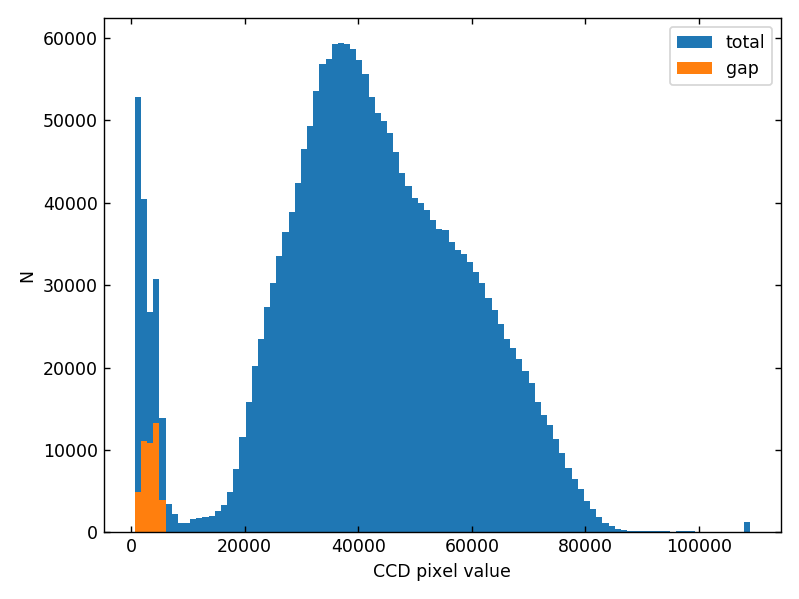

In [5]:
fig, ax = plt.subplots()
n1, bins1, x1 = ax.hist(rg.flatten(), bins=100, color='C0', label='total')
n2, bins2, x2 = ax.hist(rg[bin_msk].flatten(), bins=bins1, color='C1', label='gap')
ax.set_xlabel("CCD pixel value")
ax.set_ylabel("N")
plt.legend()
plt.tight_layout()

In [6]:
gap_upper_limit = 8000  # by zoom-in of the above histogram

<IPython.core.display.Javascript object>


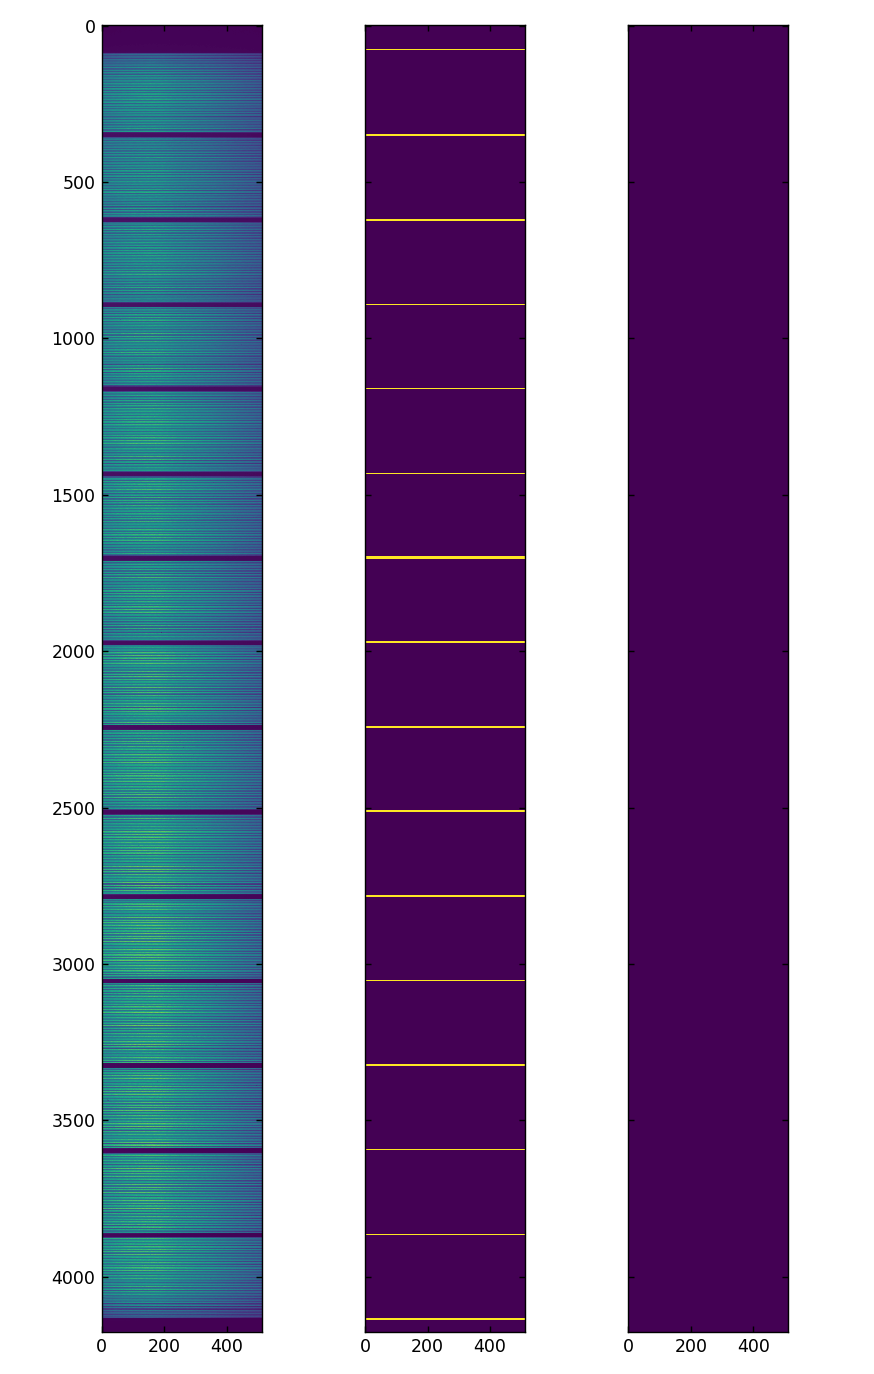

In [7]:
fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(7,11))
ax[0].imshow(rg, origin='upper')  # flat data
ax[1].imshow(int_msk, origin='upper')  # displaying gap
ax[2].imshow((bin_msk & (rg > gap_upper_limit)), origin='upper')  # check the gap upper limit
plt.tight_layout()

<IPython.core.display.Javascript object>


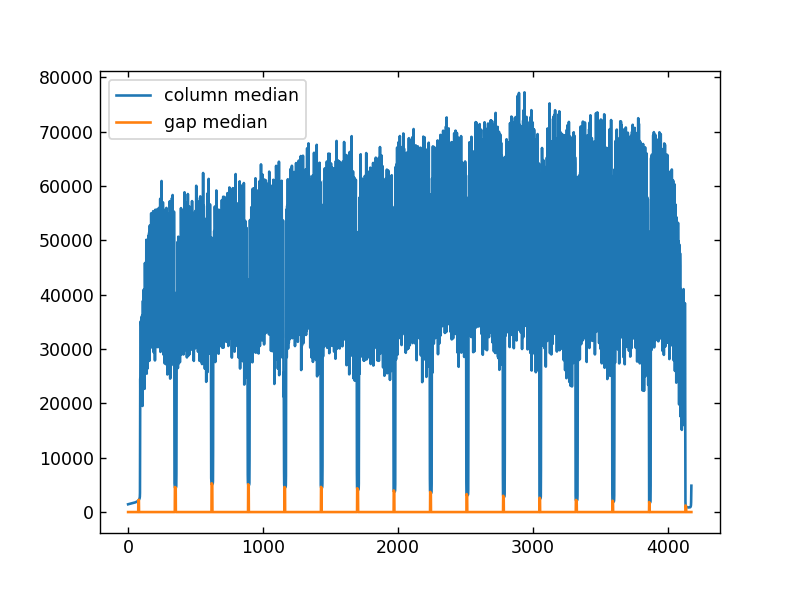

In [8]:
fig, ax = plt.subplots()
ax.plot(np.median(rg, axis=1), label='column median')
ax.plot(np.median(int_msk*rg, axis=1), zorder=+10, label='gap median')
plt.legend()

In [9]:
all_gaps_are_ok = True  # If False, new gap mask file should be written below.

if all_gaps_are_ok:
    blkmsk_name = 'blkmask_'+flat0
else:
    blkmsk_name = 'newblkmask_'+flat0+'_hdr{0:02d}'.format(hdr_num)

with open("blkmask_name.txt", "w") as f:
    f.write(blkmsk_name+"\n")

If ``all_gap_are_ok`` is ``False``, you have to check the gap manually with the following process below.

<IPython.core.display.Javascript object>


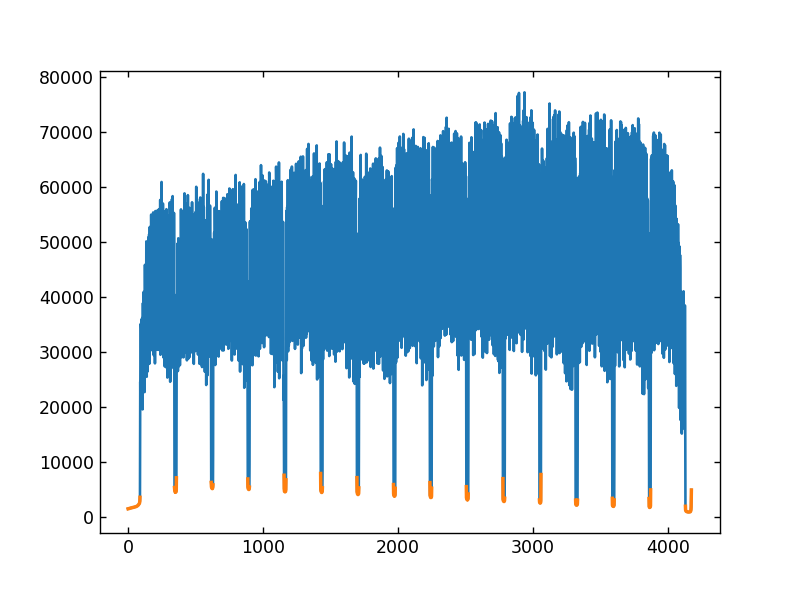

In [10]:
fig, ax = plt.subplots()
column_median = np.median(rg, axis=1)
ax.plot(column_median, label='column median')

gaps = (column_median < gap_upper_limit)
jmsk = np.zeros_like(column_median)
jmsk[~gaps] = np.nan
jmsk[gaps] = column_median[gaps]
# jmsk[:100] = np.nan  # masking the edge region
ax.plot(jmsk, linewidth=2.0, zorder=+10)

In [11]:
gap_width = 270
idx_jmsk = np.arange(len(jmsk))[np.isnan(jmsk) == False]
print(idx_jmsk)
div_jmsk = idx_jmsk / gap_width
print(idx_jmsk / gap_width)

[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   68   69
   70   71   72   73   74   75   76   77   78   79   80   81   82   83
   84   85   86   87   88  344  345  346  347  348  349  350  351  352
  353  354  355  356  357  358  616  617  618  619  620  621  622  623
  624  625  626  627  628  629  887  888  889  890  891  892  893  894
  895  896  897  898  899 1156 1157 1158 1159 1160 1161 1162 1163 1164
 1165 1166 1167 1168 1169 1170 1427 1428 1429 1430 1431 1432 1433 1434
 1435 1436 1437 1438 1439 1440 1696 1697 1698 1699 1700 1701 1702 1703
 1704 1705 1706 1707 1708 1709 1710 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 2237 2238 2239 2240 2241 2242 2243
 2244 

In [12]:
gap_half = 2

idx = idx_jmsk[div_jmsk == 0]
idx_min = idx[jmsk[idx] == np.min(jmsk[idx])]
# idx_min = idx[jmsk[idx] == np.min(jmsk[idx])]
idx_gap = np.zeros((len(np.unique(div_jmsk)), 2))

for i in np.unique(div_jmsk):
    idx = idx_jmsk[div_jmsk == i]
    idx_min = idx[jmsk[idx] == np.min(jmsk[idx])]
    jmsk[idx] = np.nan
    jmsk[int(idx_min-gap_half):int(idx_min+gap_half+1)] = column_median[int(idx_min-gap_half):int(idx_min+gap_half+1)]
    print(int(idx_min-gap_half), int(idx_min+gap_half))
    idx_gap[i] = (int(idx_min-gap_half), int(idx_min+gap_half))

(-2, 2)
(349, 353)
(622, 626)
(893, 897)
(1161, 1165)
(1433, 1437)
(1702, 1706)
(1973, 1977)
(2243, 2247)
(2514, 2518)
(2783, 2787)
(3052, 3056)
(3323, 3327)
(3593, 3597)
(3863, 3867)
(4153, 4157)


In [13]:
fig, ax = plt.subplots()
ax.plot(column_median)
ax.plot(jmsk, linewidth=2.0, zorder=+10)

<IPython.core.display.Javascript object>

In [14]:
msk_jh = np.zeros(np.shape(msk_ascii))
for i in np.arange(np.shape(msk_jh)[0]):
    msk_jh[i] = np.array([1, np.shape(rg)[1], int(idx_gap[i,0]), int(idx_gap[i,1])])
msk_jh = msk_jh.astype('int')
print(msk_jh)

[[   1  512   -2    2]
 [   1  512  349  353]
 [   1  512  622  626]
 [   1  512  893  897]
 [   1  512 1161 1165]
 [   1  512 1433 1437]
 [   1  512 1702 1706]
 [   1  512 1973 1977]
 [   1  512 2243 2247]
 [   1  512 2514 2518]
 [   1  512 2783 2787]
 [   1  512 3052 3056]
 [   1  512 3323 3327]
 [   1  512 3593 3597]
 [   1  512 3863 3867]
 [   1  512 4153 4157]]


In [15]:
if (all_gaps_are_ok == False):
    print("WTF")
    f = open(blkmsk_name, 'w')
    for i in np.arange(np.shape(msk_jh)[0]):
        f.write(str(msk_jh[i,0])+' '+str(msk_jh[i,1])+' '+str(msk_jh[i,2])+' '+str(msk_jh[i,3])+'\n')
    f.close()